# Solo para pasados y correr

/home/roberto/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


--2024-09-04 09:58:01--  https://gist.githubusercontent.com/will-henney/efd581c724e8c591a7f50e9e576f2980/raw/c520092b65fb2b88838c9d04987ceb74af86b8f1/discrete_gaussian_model.py
Resolviendo gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Conectando con gist.githubusercontent.com (gist.githubusercontent.com)[185.199.111.133]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 520 [text/plain]
Guardando como: “discrete_gaussian_model.py”

discrete_gaussian_m 100%[===================>]     520  --.-KB/s    en 0s      

2024-09-04 09:58:01 (7.82 MB/s) - “discrete_gaussian_model.py” guardado [520/520]

INFO: Found cached file ./mastDownload/HLA/hst_11137_01_wfpc2_f656n_wf/hst_11137_01_wfpc2_f656n_wf_drz.fits with expected size 55607040. [astroquery.query]
Filename: ./mastDownload/HLA/hst_11137_01_wfpc2_f656n_wf/hst_11137_01_wfpc2_f656n_wf_drz.fits
No.    Name      Ver    Type      Cards   Dimension

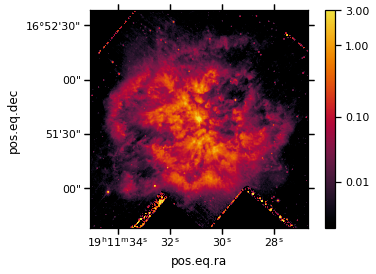

In [1]:
from astroquery.mast import Observations
from astropy.io import fits
import astropy.units as u
from astropy.wcs import WCS
import regions

from matplotlib import pyplot as plt
import seaborn as sn
sn.set_context("notebook")
import cmasher as cm

user = "will-henney"
repo = "efd581c724e8c591a7f50e9e576f2980"
src_dir = "c520092b65fb2b88838c9d04987ceb74af86b8f1"
pyfile = "discrete_gaussian_model.py"

url = f"https://gist.githubusercontent.com/{user}/{repo}/raw/{src_dir}/{pyfile}"
! wget --no-cache --backups=1 {url}

from discrete_gaussian_model import DiscreteGaussianModel

table = Observations.query_criteria(
    objectname="WR124", 
    radius="1 arcmin",
    filters=["F656N"],
    project="HLA",
    )
table.remove_column("s_region")

products = Observations.get_product_list(table)

filtered = Observations.filter_products(products,
                                        obs_id="hst_11137_01_wfpc2_f656n_wf",
                                        productSubGroupDescription='DRZ')

manifest = Observations.download_products(filtered[0], productType="SCIENCE")

fn = manifest[0]["Local Path"]

hdulist = fits.open(fn)
hdulist.info()

hdu = hdulist['SCI']
wcs = WCS(hdu)

import numpy as np
from astropy.visualization import simple_norm
from astropy.coordinates import SkyCoord

c0 = SkyCoord.from_name('wr124', cache=True)

x0, y0 = wcs.world_to_pixel(c0)
mx, my = 600, 600

fig = plt.figure()
ax = fig.add_subplot(projection=wcs)
norm = simple_norm(hdu.data, stretch='log', min_cut=0, max_cut=3)
im = ax.imshow(hdu.data, norm=norm, cmap=cm.ember)
cb = fig.colorbar(im, ax=ax, ticks=[0.01, 0.1, 1.0, 3.0])
ax.set(
    xlim=[x0 - mx, x0 + mx],
    ylim=[y0 - my, y0 + my],
)
...;

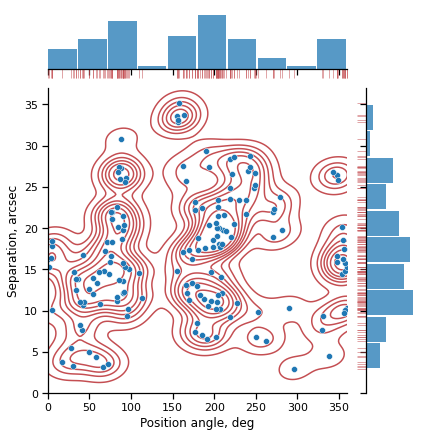

In [2]:
region_url = (
    "https://raw.githubusercontent.com/"
    "will-henney/globule-seminario/"
    "main/m1-67/m1-67-globules.reg"
    )

regs = regions.Regions.read('m1-67-globules.reg',format='ds9')#region_url, format="ds9")
regs = [_ for _ in regs if hasattr(_, 'center') and _.visual.get('marker') == "o"]

rregs = [_ for _ in regs if _.visual.get('markeredgewidth') == 3]

from astropy.table import QTable, Table

source_table = QTable(
    [
        {"ICRS": r.center, "Isolated": r.visual.get('markeredgewidth') == 3} 
        for r in regs
    ]
)

source_table["PA"] = c0.position_angle(source_table["ICRS"]).to(u.deg)
source_table["Sep"] = source_table["ICRS"].separation(c0).to(u.arcsec)
source_table["PA"].info.format = ".2f"
source_table["Sep"].info.format = ".2f"

sn.set_color_codes()
g = sn.jointplot(
    x=source_table['PA'].value, 
    y=source_table['Sep'].value,
    height=6, space=0.3, ratio=4,
    marginal_kws={'shrink': 0.95, 'lw': 0, 'bins': 10},
    )
g.plot_joint(sn.kdeplot, bw_adjust=0.4, color="r", zorder=0, levels=9)
g.plot_marginals(sn.rugplot, color="r", alpha=0.5, height=-.15, clip_on=False)
g.fig.axes[0].set(
    xlim=[0, 360],
    ylim=[0, 37],
    xlabel='Position angle, deg',
    ylabel='Separation, arcsec',
)
g.fig.axes[1].set(ylim=[0, 40])
g.fig.axes[2].set(xlim=[0, 40])
...;

In [3]:
source = source_table[0]

j1, i1 = wcs.world_to_array_index(source['ICRS'])
size = 15
yslice, xslice = slice(j1 - size, j1 + size), slice(i1 - size, i1 + size)
cutout = hdu.data[yslice, xslice]
wcutout = wcs.slice((yslice, xslice))

from astropy.nddata import Cutout2D
from astropy.coordinates import Angle

class SourceCutout:
    """Small image cut out around a given source
    """
    
    def __init__(self, pdata, hdu, size=3 * u.arcsec):
        self.center = pdata["ICRS"]
        # PA of source wrt star
        self.pa_source = pdata["PA"]
        # and PA of star wrt source
        self.pa_star = Angle(self.pa_source + 180 * u.deg).wrap_at(360 * u.deg)
        self.sep = pdata["Sep"]
        self.is_isolated = pdata["Isolated"]
        self.size = size
        self.cutout = Cutout2D(
            hdu.data, position=self.center, size=size, wcs=WCS(hdu), copy=True,
        )
        self.image = self.cutout.data
        self.wcs = self.cutout.wcs
        ny, nx = self.image.shape
        self.x, self.y = np.meshgrid(np.arange(nx), np.arange(ny))
        self.image_coords = self.wcs.pixel_to_world(self.x, self.y)
        # Radius and PA of each pixel with respect to the NOMINAL center
        self.r = self.center.separation(self.image_coords)
        self.pa = self.center.position_angle(self.image_coords)
        # Default mask has max radius of half the cutout size
        self.set_mask(r_out=self.size / 2)

        self.find_bary_center()
        # Recalculate r, pa, and masks wrt the barycenter
        self.r = self.barycenter.separation(self.image_coords)
        self.pa = self.barycenter.position_angle(self.image_coords)
        self.set_mask(r_out=self.size / 2)

        # And do photometry
        self.bright_peak = np.max(self.image[self.coremask])
        # Take the 10% centile as estimate of BG value
        self.bright_bg = np.percentile(
            self.image[self.mask],
            10,
        )
        # BG-subtracted of the core region
        self.flux_core = np.sum((self.image - self.bright_bg)[self.coremask])
        # BG-subtracted part of the outer part within the mask but excluding core
        self.flux_halo = np.sum(
            (self.image - self.bright_bg)[(~self.coremask) & self.mask]
            )

        
    def __repr__(self):
        return f"SourceCutout({self.pa_source:.1f}, {self.sep:.1f})"
       
         
    def set_mask(
        self,
        r_out = 1.0 * u.arcsec,
        r_in = 0.2 * u.arcsec,
        r_core = 0.2 * u.arcsec,
        mu_min = 0.5,
    ):
        cth = np.cos((self.pa - self.pa_star))
        self.mask = (self.r <= r_out) & ((cth >= mu_min) | (self.r <= r_in))
        self.coremask = (self.r <= r_in)

    def find_bary_center(self):
        """Refine estimate of center by using flux-weighted mean
        position within the core mask
        """
        m = self.coremask

        # Original version was flux-weighted mean
        # xbary = np.average(self.x[m], weights=self.image[m])
        # ybary = np.average(self.x[m], weights=self.image[m])

        # New version is just the peak pixel
        index = np.argmax(self.image[m], axis=None)
        xbary = self.x[m][index]
        ybary = self.y[m][index]

        self.barycenter = self.wcs.pixel_to_world(xbary, ybary)



In [4]:
cutouts = [SourceCutout(source, hdu) for source in source_table]
cutouts = sorted(cutouts, key=lambda x: x.sep.value)

best_cutouts = [cutout for cutout in cutouts if cutout.is_isolated]



In [5]:
from astropy import constants

from astropy.modeling import models, fitting
from astropy.modeling.models import Const1D
FITTER = fitting.LevMarLSQFitter()

def fit_to_cutout(cutout):
    g0 = DiscreteGaussianModel(
        amplitude=3.0, mean=0.0, stddev=0.1, 
        bin_width=0.1, fixed={"bin_width": True},
        )
    g0.mean.fixed = True
    g0.stddev.bounds = 0.01, 0.5
    g0.amplitude.bounds = 0.01, 20.0

    g1 = DiscreteGaussianModel(
        amplitude=3.0, mean=0.5, stddev=0.2,
        bin_width=0.1, fixed={"bin_width": True},
        )
    g1.mean.bounds = 0.1, 1.5
    g1.stddev.bounds = 0.01, 1.0
    g1.amplitude.bounds = 0.01, 20.0

    c0 = Const1D(amplitude=cutout.bright_bg)
    c0.amplitude.bounds = 0.0, 1.5 * cutout.bright_bg

    model = g0 + g1 + c0
    m = cutout.mask
    r = cutout.r[m].arcsec
    b = cutout.image[m]
    th = Angle(cutout.pa - cutout.pa_star).wrap_at(180*u.deg)[m]
    w = np.cos(th)**2 / (0.3 + r)**2

    cutout.fitted = FITTER(model, r, b, weights=w)
    cutout.core_sigma = cutout.fitted.stddev_0.value
    cutout.shell_radius = cutout.fitted.mean_1.value
    cutout.shell_sigma = cutout.fitted.stddev_1.value
    cutout.core_peak = cutout.fitted[0](0.0)
    cutout.shell_peak = cutout.fitted[1](cutout.shell_radius)
    cutout.bg_fit_level = cutout.fitted.amplitude_2.value

In [6]:
for cutout in cutouts:
    fit_to_cutout(cutout)

# Errores en el brillo

Ahora vamos a considerar los errores en el brillo. Para esto primero vemos a tomar a tomar en cuenta el valor en la parte de la segunda gaussiana  y su ajuste $y-f(x)$. Para esto le vamos a sacar el promedio de $(y-f(x)^2$ considerando dos pesos, uno que es el del ajuste y el otro que es el de la segunda gaussiana para que lo demas no perjudique. Finalmente a esta varianza le sacaremos su raís cuadrada.

Con esto podemos ver que porcentaje de error con respecto al brillo en la cáscara tiene

In [7]:
SS = [
    2,6,9,13,14,15,17,28,32,35,43,51,52,72,82,100,111,125,127,133,135,141,143,144,147,156
]
err_Bs = []
''' Para el brillo en la cascara '''
for idx, cutout in enumerate(cutouts):
    if idx in SS:
        m = cutout.mask
        r = cutout.r[m].arcsec
        #bm = ((cutout.shell_radius-cutout.shell_sigma/2)<r) & (r<(cutout.shell_radius+cutout.shell_sigma/2)) 
        x = (cutout.image[m]-cutout.fitted(cutout.r[m].arcsec))
        
        th = Angle(cutout.pa - cutout.pa_star).wrap_at(180*u.deg)[m]
        w = np.cos(th)**2 / (0.3 + r)**2
        
        gauss = cutout.fitted[1](r)
        
        prom = np.average(x,weights=w*gauss)
        var = np.average(x**2,weights=w*gauss)
        std = var**(1/2)
        var1 = np.average((x-prom)**2,weights=w*gauss)
        std1 = var1**(1/2)
        err_Bs.append((std1/cutout.shell_peak).value)
        #print(prom, '   en   ',idx, 'std es   ', std1, '  std/valor_pico  ' , std1/cutout.shell_peak)#, '   es   ', err)
err_Bs

[0.3661810247113008,
 0.21083054928283457,
 0.23058741582207665,
 0.3310108574590412,
 0.18363665743796317,
 0.2034036780873527,
 0.26122216919147945,
 0.45837032462435773,
 0.28242295687897406,
 0.3459230408442377,
 0.16264923111336244,
 0.38505808051309787,
 0.5107090184537154,
 0.5980728389607591,
 0.5040670113015576,
 0.21919908262856405,
 0.30291082196421243,
 0.127684150955794,
 0.159611999183567,
 0.4876000953976853,
 0.632675055452998,
 0.09612625039525882,
 0.25909789120758625,
 0.3439754261512716,
 0.5149757490438993,
 0.15250516307670828]

# Errores para el Bcore

De manera similar, ahora vamos a considerar solo para la primer gaussiana, por lo que el peso del ajuste cmabiara pero con la misma idea anterior. También considerar que como es en la parte del core el error se medirá con el brillo en el core

In [8]:
''' Para e brillo en el core '''
err_Bc = []
for idx, cutout in enumerate(cutouts):
    if idx in SS:
        m = cutout.mask
        r = cutout.r[m].arcsec
        #bm = ((cutout.shell_radius-cutout.shell_sigma/2)<r) & (r<(cutout.shell_radius+cutout.shell_sigma/2)) 
        x = (cutout.image[m]-cutout.fitted(cutout.r[m].arcsec))
        
        th = Angle(cutout.pa - cutout.pa_star).wrap_at(180*u.deg)[m]
        w = np.cos(th)**2 / (0.3 + r)**2
        
        gauss = cutout.fitted[0](r)
        
        prom = np.average(x,weights=w*gauss)
        var = np.average(x**2,weights=w*gauss)
        std = var**(1/2)
        var1 = np.average((x-prom)**2,weights=w*gauss)
        std1 = var1**(1/2)
        err_Bc.append((std1/cutout.core_peak).value)
        #print(prom, '   en   ',idx, 'std es   ', std1, '  std/valor_pico  ' , std1/cutout.core_peak)
err_Bc

[0.12313373622387686,
 0.06980169082696731,
 0.13783617751347033,
 0.09467361114910618,
 0.04892815890222323,
 0.07123193369894042,
 0.057468107006198546,
 0.11085748730476667,
 0.08638300779210628,
 0.0731304740204209,
 0.07468012978852834,
 0.11244393818848986,
 0.1455627796972857,
 0.13425156695945337,
 0.10340370769967296,
 0.09449705149224828,
 0.08190278259270901,
 0.04986201128405987,
 0.1126436249310836,
 0.03575454668679886,
 0.07763309694111274,
 0.08858159747598048,
 0.08493835084508398,
 0.1371594142596184,
 0.17293934721059742,
 0.09141635504220608]

## Errores de brillo para otros ajustes

En este caso tenemos una medición sobre los que se detecto bien en ambos telescopios, por lo que en los ajustes recuperados vamos darle un error de sus brillos como la media de estos valores.

In [9]:
print(np.mean(err_Bs),np.mean(err_Bc))

0.3204040976976791 0.09504287252050021


Para la parte de la cáscara en algunos casos se detectó un error grande, pero esto se debía principalmente a que el brillo en la cáscara era muy bajo, pero en realidad el ajuste era lo suficientemente bueno como para seguir considerandolo.

Por otro lado como en el core tenemos un mayor brillo el error en general fue menor, incluso vemos que la media es del $\sim 10\%$

In [10]:
rc_fonts = {
        "text.usetex": True,
        "font.size": 30,
        'mathtext.default': 'regular',
        'axes.titlesize': 33,
        "axes.labelsize": 33,
        "legend.fontsize": 30,
        "xtick.labelsize": 30,
        "ytick.labelsize": 30,
        'figure.titlesize': 33,
        'figure.figsize': (13,11),
        'text.latex.preamble': [r'\usepackage{amsmath,amssymb,bm,physics,lmodern}'],
        "font.family": "serif",
        "font.serif": "computer modern roman",
        }

plt.rcParams.update(rc_fonts)

/home/roberto/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [11]:
''' Resultados del combo neutro D '''
r0 = QTable.read('r0.ecsv')

''' Resultados de HST '''
HST = QTable.read('/home/roberto/Escritorio/astrofísica/Untitled Folder/Untitled Folder/m1-67-globule-parameters.ecsv')

''' Resultados JWST '''
JWST = QTable.read('JWST-combo-E.ecsv')


''' buenos ajustes en HST '''
Sel_HST = [
    2,6,9,13,14,15,17,28,32,35,43,51,52,72,82,100,111,125,127,133,135,141,143,144,147,153,156
]
''' Buenos ajustes en JWST '''
Sel_jw = [
    8,9,11,13,14,24,28,31,35,38,43,52,71,80,82,100,117,118,125,127,135,138,143,144,152,153,156
]

''' Ajustes en los que tenemos cáscaras en HSTy JWST '''
comun = []
for i in Sel_jw:
    if i in Sel_HST:
        comun.append(i)
        
comun

[9, 13, 14, 28, 35, 43, 52, 82, 100, 125, 127, 135, 143, 144, 153, 156]

In [12]:
''' Correción para datos de HST '''
r_FH = 2*np.sqrt(2*np.log(2))*HST['Rcore'].value
r_CH = (np.sqrt(r_FH**2-0.067**2))/2

''' Correción para datos de JWST '''
r_FJ = 2*np.sqrt(2*np.log(2))*r0['Rcore'].value
r_CJ = (np.sqrt(r_FJ**2-0.145**2))/2

## Errores en Rshell

Para este caso vamos a considerar el error dado por 
$$\sigma(Rshell_{HST}-Rshell_{JWST})/\sqrt(2)$$

y lo vamos a considerar sobre la media de los radios en el JWST

In [13]:
err_Rshell = (np.std(HST['Rshell'][comun]-JWST['Rshell'][comun])/np.sqrt(2))/np.mean(JWST['Rshell'][comun])
'''error en cascarra'''
err_Rshell

<Quantity 0.10097906>

In [14]:
''' Correción para datos de HST '''
h_FH = 2*np.sqrt(2*np.log(2))*HST['Hshell'].value
h_CH = (np.sqrt(h_FH**2-0.067**2))/2

''' Correción para datos de JWST '''
h_FJ = 2*np.sqrt(2*np.log(2))*JWST['Hshell'].value
h_CJ = (np.sqrt(h_FJ**2-0.145**2))/2

<ipython-input-14-ee28d2a91fea>:7: RuntimeWarning: invalid value encountered in sqrt
  h_CJ = (np.sqrt(h_FJ**2-0.145**2))/2


## Error en Hshell

Para este caso vamos a considerar el error dado por 
$$\sigma(Hshell_{HST}-Hshell_{JWST})/\sqrt(2)$$
y este valor lo compararemos con la media de los valores de Hshell

In [15]:
err_Hshell = (np.std(HST['Hshell'][comun]-JWST['Hshell'][comun])/np.sqrt(2))/(np.mean(HST['Hshell'][comun]))
err_Hshell

<Quantity 0.24972204>

In [16]:
''' Globulos a agregar  '''
add = [
    8,11,24,31,38,71,80,117,118,138,152
]

Bshell_add = [
    .5,.625,.4,.55,.55,.33,.5,.4,.29,.11,.14
]

glo = []
for i in Sel_jw:
    glo.append(i)

for i in Sel_HST:
    if i not in glo:
        glo.append(i)

for i in add:
    if i not in glo:
        glo.append(i)

Glo = sorted(glo)

malos = [8,9,71,118,138,141,143,156]
for i in malos:
    Glo.remove(i)

R1 = []
for i in Glo:
    if i in Sel_jw:
        R1.append(JWST['Rshell'][i])
    elif i in Sel_HST:
        R1.append(HST['Rshell'][i])

H = []
for i in Glo:
    if i in Sel_jw:
        H.append(JWST['Hshell'][i])
    elif i in Sel_HST:
        H.append(HST['Hshell'][i])

Bs = []
for i in Glo:
    if i in Sel_HST:
        Bs.append(HST['Bshell'][i])
    elif i in add:
        Bs.append(Bshell_add[add.index(i)])

## Errores en Rcore

como tenemos una gran dispersión y ninguna tendencia en los radios para la parte neutra, tenemos un problema. Algo a considerar es que tanto sus medias, distribuciones y desviaciones estánadar se parecen mucho, por lo que vamos a considerdar solo unn radio constante, el cual será el promedio de ambas medias  y para su error vamos a considerar la diferencia de estas medias

In [17]:
r_0 = (.12+.15)/2
err_r0 = .03/.135

In [18]:
error_Bs = []
for i in Glo:
    if i in SS:
        error_Bs.append(err_Bs[SS.index(i)])
    else:
        error_Bs.append(np.mean(err_Bs))

error_Bc = []
for i in Glo:
    if i in SS:
        error_Bc.append(err_Bc[SS.index(i)])
    else:
        error_Bc.append(np.mean(err_Bc))

print(len(error_Bs),len(error_Bc))

30 30


# Errores

Como todos los errores estimados antes son el porcentaje con respecto a sus valores reales, tenemos que lo serrores como tales serán este porcetaje multiplicado por su valor. 

Solo para el caso del radio en la parte neutra tenemos un error constante, mientras que para los demas tenemos un error para cada glóbulo que dependerá de su valor

In [19]:
x_Bc = [i for i in HST['Bcore'][Glo]]
'''error_Bc'''
e_Bc = [x_Bc[i]*error_Bc[i] for i in range(len(error_Bc))]
'''Bs'''
'''error_Bs'''
e_Bs = [Bs[i]*error_Bs[i] for i in range(len(error_Bs))]
x_r0 = [r_0]
e_r0 = [err_r0*r_0]
x_H = [i.value for i in H]
e_H = [i*err_Hshell.value for i in x_H]
x_r1 = [i.value for i in R1]
e_r1 = [err_Rshell.value*i for i in x_r1]

In [20]:
from uncertainties import ufloat
from uncertainties import unumpy
f_Bs = unumpy.uarray(Bs,e_Bs)
f_Bs

array([0.4084171491871912+/-0.14955461019903388,
       0.17174456292659362+/-0.03620900053815408,
       0.625+/-0.20025256106104944,
       0.2626446321104952+/-0.08693822488190944,
       0.33588330570548364+/-0.06168048754896856,
       0.6429309061994105+/-0.13077451107699486,
       0.5937832447710543+/-0.15510934722865, 0.4+/-0.12816163907907163,
       0.1470546909634152+/-0.06740550643443523,
       0.55+/-0.17622225373372352,
       0.22196587790154146+/-0.06268825956319067,
       0.44601517523475737+/-0.1542869256798828,
       0.55+/-0.17622225373372352,
       0.6631794901831244+/-0.10786563416843688,
       0.3498841761571231+/-0.13472572927296841,
       0.22051894043153777+/-0.11262101161824399,
       0.10473862322669499+/-0.06264132574203078,
       0.5+/-0.16020204884883954,
       0.22097938693061725+/-0.11138841912936671,
       0.6179689979352966+/-0.13545823744031,
       0.29751255279533384+/-0.09011977191190572,
       0.4+/-0.12816163907907163,
       0.42171

In [21]:
f_Bc = unumpy.uarray(x_Bc,e_Bc)
f_H = unumpy.uarray(x_H,e_H)
f_r0 = unumpy.uarray(x_r0,e_r0)
f_r1 = unumpy.uarray(x_r1,e_r1)

# Propiedades

Debido a que uncertainties hace los calculos de los errores cuando estos se combinan en un afunción, ahora podemos sacar sus propiedades con sus respectivos errores 

In [22]:
'''   Densidad   '''
from astropy import constants as cte
D = 5429*u.pc                      # conversation with Jane
v_inf = 710*u.km*(1/u.second)      # Hanmman
M_loss = (2.0E-5)*u.M_sun*(1/u.yr) #Crowther 1999
L = 10**(49.1)*(1/u.second)        # Hanmman

E = (cte.h*cte.c/(6562.8*u.AA)).cgs
EM = f_Bs*4*np.pi*0.0137/(1.17e-13*E.value*u.cm**5)
n  = ((EM/(2*(2*f_r1*f_H)**(1/2)*(D.value*u.AU)))**(1/2)).cgs
n

'''   Presion   '''
cs2 = (cte.k_B*6000*u.K/(0.6*cte.m_p)).to('km**2/s**2')
Pg = (n*cte.m_p*cs2).cgs
Pr = ((M_loss*v_inf)/(4*np.pi*((HST['Sep'][Glo].value*D.value)*u.AU)**2)).cgs

'''   cos(i)   '''
cos = (Pg/Pr)**(2/5)

R = HST['Sep'][Glo]/cos

Text(0.5, 1.0, 'Presiones de los glóbulos y RAM ')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


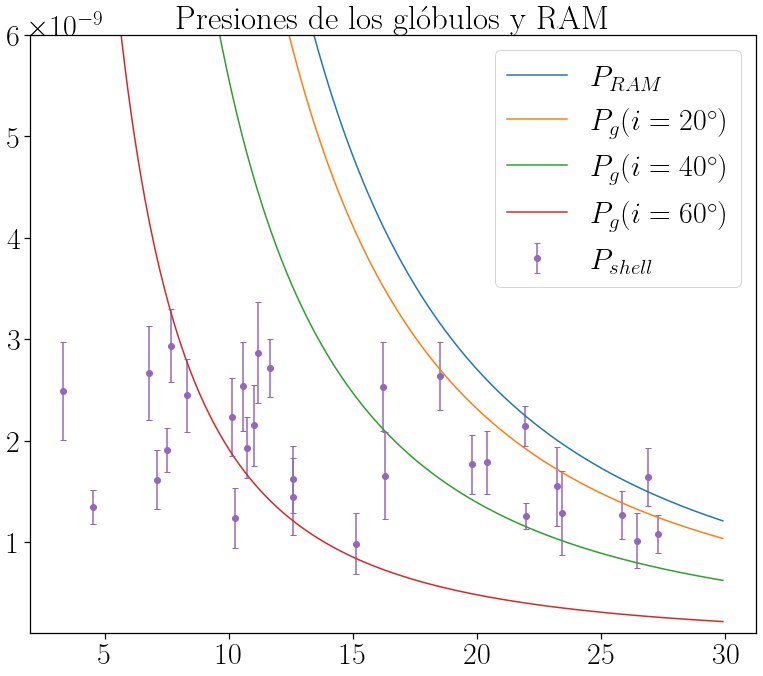

In [23]:
rang = np.arange(5,30,0.1) #the range in what we see the globules
distances = rang*D.value*u.AU
P_r = (M_loss*v_inf)/(4*np.pi*(distances.to('cm'))**2)
fig, ax = plt.subplots()
ax.plot(rang,P_r.cgs,label=r'$P_{RAM}$')
ax.plot(rang,P_r.cgs*np.cos(20*u.deg)**(5/2),label=r'$P_{g}(i=20^\circ)$')
ax.plot(rang,P_r.cgs*np.cos(40*u.deg)**(5/2),label=r'$P_{g}(i=40^\circ)$')
ax.plot(rang,P_r.cgs*np.cos(60*u.deg)**(5/2),label=r'$P_{g}(i=60^\circ)$')
ax.errorbar(HST['Sep'][Glo].value,[(Pg[i].value).n for i in range(len(Pg))],yerr=[(Pg[i].value).s for i in range(len(Pg))],marker='o',capsize=3,linestyle='',label=r'$P_{shell}$')
plt.ylim(1e-10,0.6e-8)
plt.legend()
plt.title('Presiones de los glóbulos y RAM ')

In [24]:
from scipy.optimize import fsolve

def find_root(x):
    """Should be called with vector argument of same length as P_P_0"""
    return ((1+x**2)/2)*(np.e**((1-x**2)/2)) - P_P0 #equation to find the root

#M0 = fsolve(func_to_find_M0, 1.5 * np.ones_like(P_P_0)) 

P_P0 = np.arange(0.001,1.01,0.001)
M0 = fsolve(find_root,1.5 * np.ones_like(P_P0))
alpha=2      #spherical case
rho1 = np.exp((1-M0**2)/2)
r1 = (M0**(-1/alpha))*np.exp((M0**2-1)/(2*alpha))
rho2 = (M0**2)*rho1
h2 = (3/(4*M0**2)) * r1

/home/roberto/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


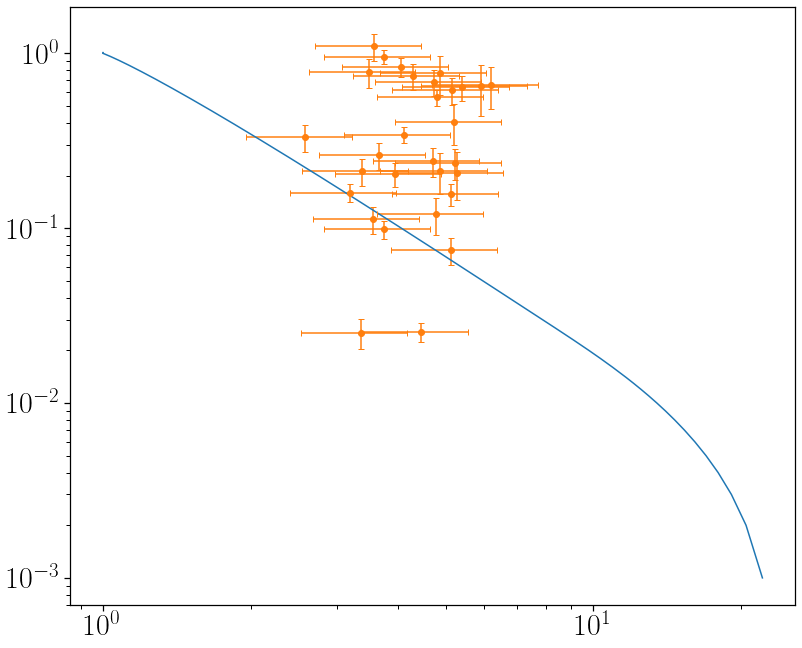

In [25]:
x = f_r1/f_r0

plt.plot(r1,P_P0,label=rf'$P/P_0$')

plt.errorbar([x[i].n for i in range(len(x))],[(Pg[i].value).n/Pr[i].cgs.value for i in range(len(Pg))],
             xerr=[x[i].s for i in range(len(x))],
             yerr=[(Pg[i].value).s/Pr[i].cgs.value for i in range(len(Pg))],
             linestyle='',marker='o',capsize=3)
plt.xscale('log')
plt.yscale('log')

# Comparación con el modelo

Para compararlo con el modelo tenemos que en nuestro caso lo podemo comparar con la siguiente función, al menos para las presiones,

$$f=\frac{1}{2}\Big(\frac{B_{shell}/B_{core}}{l_{shell}/l_0}\Big)^{1/2}$$

donde vamos a considerar que $l_0\approx r_0$

In [26]:
l_s = 2*(2*f_H*f_r1)**(1/2)
BB = (f_Bs/f_Bc)**(1/2)
f_obs = 0.5*BB*(f_r0/l_s)**(1/2)

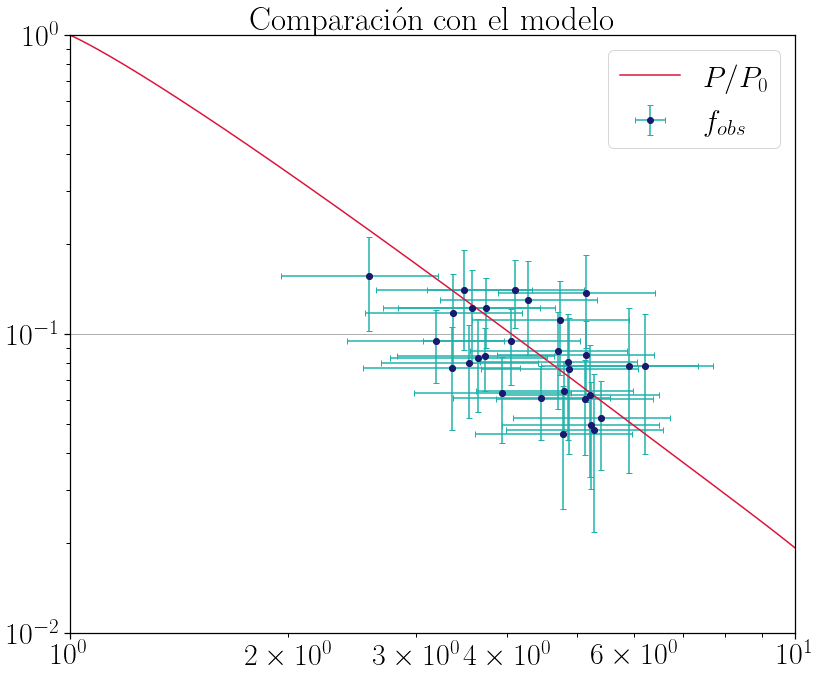

In [27]:
plt.plot(r1,P_P0,label=rf'$P/P_0$',color='crimson')
#plt.scatter([x[i].n for i in range(len(x))],[f_obs[i].n/1.63 for i in range(len(f_obs))],
 #            color='midnightblue',s=60,alpha=1)
plt.errorbar([x[i].n for i in range(len(x))],[f_obs[i].n/1.63 for i in range(len(f_obs))],
                xerr=[x[i].s for i in range(len(x))],
                yerr=[f_obs[i].s for i in range(len(f_obs))],
                marker='o',linestyle='',capsize=3,ecolor='lightseagreen',alpha=1,color='midnightblue',
                label= r'$f_{obs}$')

plt.scatter([x[i].n for i in range(len(x))],[f_obs[i].n/1.63 for i in range(len(f_obs))],
             color='midnightblue',s=30,alpha=1)
plt.yscale('log')
plt.xscale('log')
plt.ylim(.01,1)
plt.xlim(1,10)
plt.legend()
plt.title('Comparación con el modelo')
plt.grid()

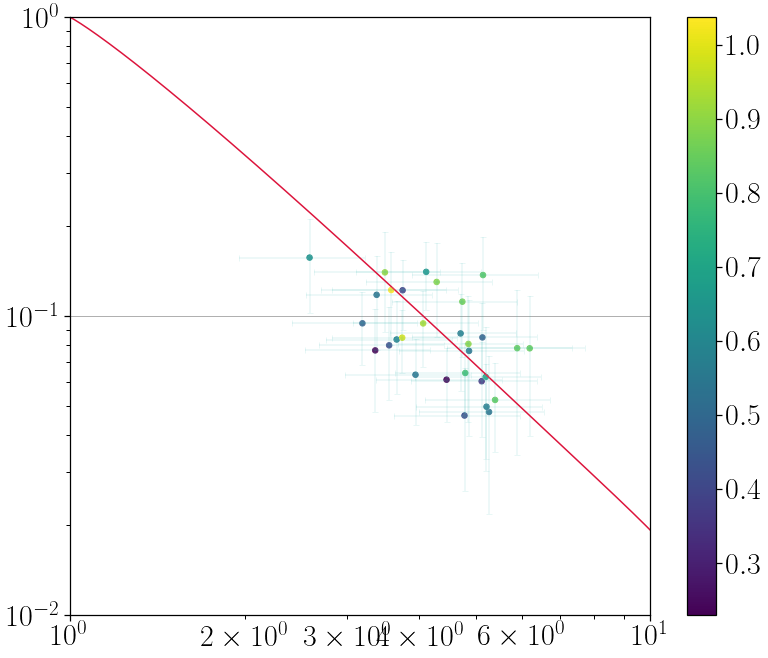

In [28]:
plt.plot(r1,P_P0,label=rf'$P/P_0$',color='crimson')
plt.errorbar([x[i].n for i in range(len(x))],[f_obs[i].n/1.63 for i in range(len(f_obs))],
                xerr=[x[i].s for i in range(len(x))],
                yerr=[f_obs[i].s for i in range(len(f_obs))],
                marker='o',linestyle='',capsize=3,ecolor='lightseagreen',alpha=0.1,color='w')
g = plt.scatter([x[i].n for i in range(len(x))],[f_obs[i].n/1.63 for i in range(len(f_obs))],
             c=[(cos[i].value).n for i in range(len(cos))],s=30)
plt.colorbar(g)
plt.yscale('log')
plt.xscale('log')
plt.ylim(.01,1)
plt.xlim(1,10)
plt.grid()

# Otros

Ahora vabmos a tratar de darle una estimacion a 
$$\frac{n_s}{n_0}$$
de dos maneras, una será a traves de la anterior $f$ y la otra será estimando una densidad $n_0$ usando la EM y $l\approx r_0$

In [29]:
EM0 = (f_Bc*4*np.pi*.037)/(1.17e-13*E.value*u.cm**5)
n0 = (EM0/(2*u.AU*(2)**(1/2)*f_r0*D.value))**(1/2)
n0.cgs

<Quantity [7043.353598786238+/-894.7043817457934,
           4748.3693049419735+/-553.0117328187276,
           7249.711689753227+/-876.1049639429912,
           5784.143415974503+/-698.5763662638985,
           3386.4287428813395+/-385.2822921005727,
           6741.623489486727+/-786.6112913756303,
           6256.735818286772+/-718.0629985703866,
           4111.848810569964+/-496.90405744204855,
           5775.7894482600295+/-717.1759553778365,
           6595.195972770704+/-797.008788375406,
           6574.498705315272+/-783.7504280941004,
           5331.053154922477+/-623.5895733044973,
           3968.724879727119+/-479.6079784203575,
           4200.25612804692+/-492.34383000038804,
           7062.131701874105+/-879.4151599926635,
           4106.817390608901+/-545.4931075395442,
           4461.42538319657+/-579.1533305521194,
           4008.3337219486752+/-484.39458301532187,
           5738.620055170809+/-703.273933160836,
           6054.3236290489085+/-730.99789665152

In [30]:
rho1_rho0_cos = n/cos**(1/2)/n0.cgs
rho1_rho0 = n/n0.cgs
rho1_rho0

<Quantity [0.256138286093237+/-0.05962751902507906,
           0.2043944956367276+/-0.03493352173676882,
           0.26633000774175075+/-0.05637365763368402,
           0.2020621304344225+/-0.04357865390704919,
           0.40699882086477274+/-0.06551245289407792,
           0.31556175393976277+/-0.053265764903370205,
           0.28309259423311084+/-0.05278401443326248,
           0.3929036421557072+/-0.08316530155096423,
           0.1550830839038695+/-0.041751272443910706,
           0.2784937543993404+/-0.05894833893014062,
           0.21234304607910046+/-0.04176563350657569,
           0.2919149003404007+/-0.06404406003437847,
           0.5234130132214662+/-0.11079001671104709,
           0.46890961732841674+/-0.07397562954291913,
           0.16596878412466815+/-0.039662333322415144,
           0.255084127572415+/-0.07540469829567846,
           0.1594281954981517+/-0.053070482215865813,
           0.4575979171267613+/-0.0968590379008464,
           0.20879401118940988+/-0.060

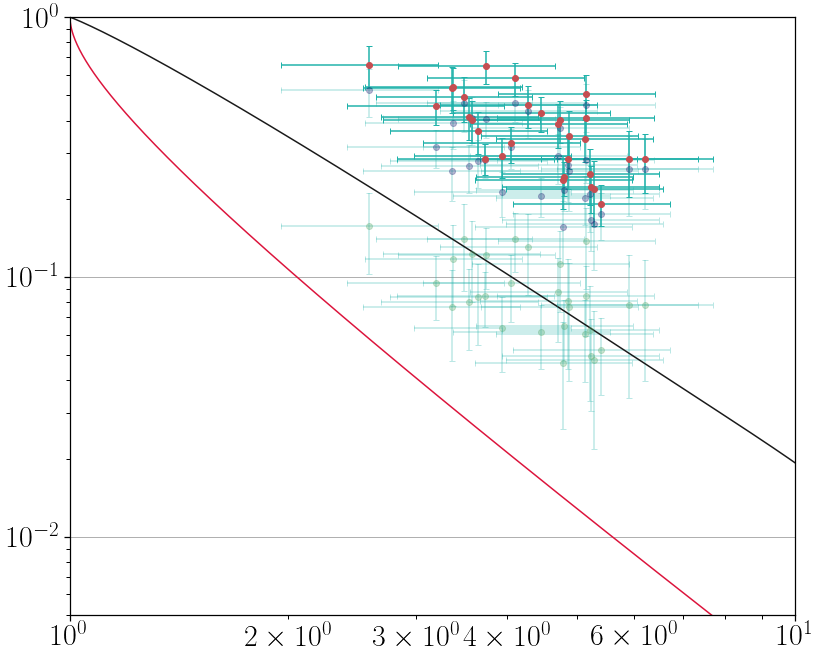

In [31]:
plt.plot(r1,P_P0,label=rf'$P/P_0$',color='k')
plt.plot(r1,rho1,label=rf'$\rho_1/\rho_0$',color='crimson')

plt.errorbar([x[i].n for i in range(len(x))],[(rho1_rho0[i].value).n for i in range(len(rho1_rho0))],
                xerr=[x[i].s for i in range(len(x))],
                yerr=[(rho1_rho0[i].value).s for i in range(len(rho1_rho0))],
                marker='o',linestyle='',capsize=3,ecolor='lightseagreen',alpha=0.3,color='midnightblue')
plt.errorbar([x[i].n for i in range(len(x))],[(rho1_rho0_cos[i].value).n for i in range(len(rho1_rho0))],
                xerr=[x[i].s for i in range(len(x))],
                yerr=[(rho1_rho0_cos[i].value).s for i in range(len(rho1_rho0))],
                marker='o',linestyle='',capsize=3,ecolor='lightseagreen',alpha=1,color='r')
plt.errorbar([x[i].n for i in range(len(x))],[f_obs[i].n/1.63 for i in range(len(f_obs))],
                xerr=[x[i].s for i in range(len(x))],
                yerr=[f_obs[i].s for i in range(len(f_obs))],
                marker='o',linestyle='',capsize=3,ecolor='lightseagreen',alpha=0.3,color='g')

#plt.colorbar(g)
plt.yscale('log')
plt.xscale('log')
plt.ylim(.005,1)
plt.xlim(1,10)
plt.grid()

In [32]:
ns_n0 = ((f_r0/l_s)*(f_Bs/(f_Bc*1.63)))**(1/2)
ns_n0

array([0.1960418439062118+/-0.045637413115874936,
       0.15643843964161758+/-0.0267372446340216,
       0.20384233298977733+/-0.04314698891294217,
       0.15465330559587737+/-0.033354012776437236,
       0.3115067275844114+/-0.050141594449097014,
       0.2415230813487621+/-0.04076828547580099,
       0.21667199783420982+/-0.040399565703747,
       0.3007186300045481+/-0.06365264370954829,
       0.11869671727290854+/-0.031955380666346136,
       0.21315216073920584+/-0.045117585642259136,
       0.16252206153536716+/-0.03196637226486207,
       0.223424370480869+/-0.04901772324583065,
       0.400607241508172+/-0.08479591041898193,
       0.3588917041982429+/-0.056619098382026736,
       0.1270283602148732+/-0.03035655886023496,
       0.1952350173152188+/-0.05771287189645446,
       0.12202235711345653+/-0.040618820986422055,
       0.3502340115156286+/-0.07413348733875574,
       0.15980571891250306+/-0.04606024306434443,
       0.24133858861498014+/-0.042577645968253496,
       

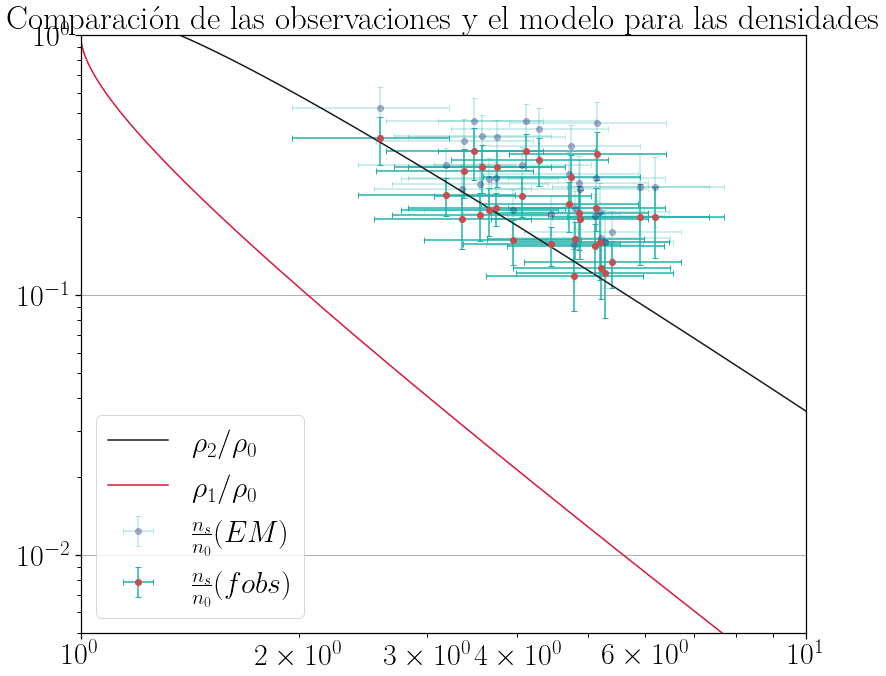

In [33]:
#plt.plot(r1,P_P0,label=rf'$P/P_0$',color='g')
plt.plot(r1,rho2,label=rf'$\rho_2/\rho_0$',color='k')
plt.plot(r1,rho1,label=rf'$\rho_1/\rho_0$',color='crimson')

plt.errorbar([x[i].n for i in range(len(x))],[(rho1_rho0[i].value).n for i in range(len(rho1_rho0))],
                xerr=[x[i].s for i in range(len(x))],
                yerr=[(rho1_rho0[i].value).s for i in range(len(rho1_rho0))],
                marker='o',linestyle='',capsize=3,ecolor='lightseagreen',alpha=0.3,color='midnightblue',
                label=r'$\frac{n_s}{n_0}(EM)$')
plt.errorbar([x[i].n for i in range(len(x))],[(ns_n0[i]).n for i in range(len(rho1_rho0))],
                xerr=[x[i].s for i in range(len(x))],
                yerr=[(ns_n0[i]).s for i in range(len(ns_n0))],
                marker='o',linestyle='',capsize=3,ecolor='lightseagreen',alpha=1,color='r',
                label=r'$\frac{n_s}{n_0}(fobs)$')

#plt.colorbar(g)
plt.yscale('log')
plt.xscale('log')
plt.ylim(.005,1)
plt.xlim(1,10)
plt.legend()
plt.title('Comparación de las observaciones y el modelo para las densidades')
plt.grid()

# Bertoldi

Ahora vamos a tratar de encontrar los parametros iniciales del paper de Bertoldi. Para esto vamos a estimar su radio y densidad inicial.

Para el caso del radio vamos a considerar como cota inferior el radio asctual en la parte neutra, y como cota superior primero vamos a considerar un grupo de glóbulos, en específico, vamos a ocupar un grupo de 15 glóbulos que se encuentran en un radio de $\sim 7"$. Este grupo lo vmaos a considerar que esta dentro de una esfera, por lo que vmaos a tomar el radio $\Big(\frac{V}{N}\Big)^{1/3}$ donde V es el volumen de la esfera y N el número de glóbulos dentro de esta esfera.

Para el caso de la densidad, en la cota inferior vamos a considerar la media de las densidades antes calculadas con la EM. Para la cota superior primero vmoas a considerar todo el flujo de $H\alpha$ en la nebulosa y vamos a ocupar la VEM para estimar la masa total ionizada. Vamos a suponer que toda esta masa estaba inicialmente distribuida de manera euqitativa en los glóbulos. Por lo que para la densidad vamos a considerar 
$n_0 = (VEM\frac{m_p}{\bar{n_e}})/V168$ donde $\bar{n_e}$ es la densidad promedio en el gas ionizado.

In [38]:
'''   r   '''
radius_ = (58.773-51.798)*u.arcsec
Vol_ = (4/3)*np.pi*(radius_.value*D.value*u.AU)**3

r_inf = r_0*D.value*u.AU
r_max = ((Vol_/15)**(1/3)).to('pc')

'''   n   '''
flux = 2.08e-10*u.erg/u.s/u.cm**2
L_neb = 4*np.pi*(D.to('cm'))**2*flux
VEM = L_neb/(1.17e-13*u.cm**3/u.s*E)
n0_B = (((VEM*cte.m_p.cgs/10*u.cm**3)/168).to('M_sun'))/((4/3)*np.pi*(r_max.cgs)**3)

n_inf = (np.mean(n0.cgs).value).n
n_max = ((n0_B/cte.m_p).cgs).value

In [39]:
'''   eta   '''
eta_inf = 702*(r_inf.to('pc')).value*n_inf
eta_max = 702*(r_max.to('pc')).value*n_max
print(np.log10(eta_inf),np.log10(eta_max))

4.086844569226424 5.688785392477005


In [ ]:
'''   Gamma   '''
R_0 = 0.01
gamma_inf = 2.79e-3*()